# Problem and Data


## Anomaly Detection on Taxi Calls

**We are contacted by a Taxi company:**

<center><img src="assets/sized-yellow-taxi.jpg" width="750px"/></center>

## Obtain the dataset

Let's start by downloading the dataset attached to this tutorial

In [4]:
!wget -O https://github.com/lompabo/aiiti-01-2021/releases/download/data/data.zip
!unzip -o data.zip
!ls .

wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.
Archive:  data.zip
  inflating: data/nab/labels/combined_windows.json  
  inflating: data/nab/labels/combined_windows_tiny.json  
  inflating: data/nab/labels/combined_labels.json  
  inflating: data/nab/labels/raw/known_labels_v1.0.json  
  inflating: data/nab/labels/raw/CB_labels_v1.0.json  
  inflating: data/nab/labels/raw/CB_labels_v0.8.json  
  inflating: data/nab/labels/raw/AL_labels_v1.0.json  
  inflating: data/nab/labels/raw/AL_labels_v0.8.json  
  inflating: data/nab/labels/raw/SA_labels_v0.8.json  
  inflating: data/nab/labels/raw/SA_labels_v1.0.json  
  inflating: data/nab/data/realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv  
  inflating: data/nab/data/realAWSCloudwatch/._ec2_cpu_utilization_825cc2.csv  
  inflating: data/nab/data/realAWSCloudwatch/ec2_network_in_257a54.csv  
  inflating: data/nab/data/realAWSCloudwatch/._ec2_network_in_257a54.csv  
  inflating: data/nab/data/realAWSCl

'1. Problem and Data.ipynb'			     README.md
'2. Anomaly Detection as Density Estimation.ipynb'   assets
'3. KDE for Anomaly Detection.ipynb'		     data
'4. Combining Observations.ipynb'		     data.zip
'5. Time-Dependent Estimator.ipynb'		     docker-compose.yml
 Dockerfile					     util
 LICENSE


## Anomaly Detection on Taxi Calls

**We are contacted by a Taxi company:**

* They have historical data about taxi calls in NYC
* They are interested in detecting "abnormal situations" (so called _anomalies_)

**Goals:**

* Analyze anomalies (e.g. better size the fleet)
* Anticipate anomalies (so we can prepare)

**Typically referred to as _anomaly detection_:**

* An important industrial problem
* Many context and possible applications

## Basic Setup

**Let us start by setting up the notebook:**

The tutorial comes witha companion moduler that contains a pre-built function:

```python
def load_series(file_name, data_folder):
    ...
```

...Which of course loads our dataset

* We will use data from the [Numenta Anomaly Benchmark (NAB)](https://github.com/numenta/NAB)
* NYC taxi data `nyc_taxi.csv` is in the `data/realKnownCause` folder

In [5]:
from util import nab # Import our submodule
import os
data_folder = os.path.join('data', 'nab')
file_name = os.path.join('realKnownCause', 'nyc_taxi.csv')
data, labels, windows = nab.load_series(file_name, data_folder)

## A Look at the Data

**Let's have a look at all the data we loaded**

In [6]:
data.head()

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820


`data` is a pandas `DataFrame` object

* It is essentially a _table_, in this case representing a _time series_
* There are well defined _column names_ (here "value")
* There is a well defined row _index_ (here "timestamp")
* Jupyter displays DataFrame objects as HTML tables

## Time Series and Pandas

**Our data is a time series**

I.e. a sequence whose index represents time

* Specifically, we have a _univariate_ time series...
* ...Since we are tracking only quantity (i.e. one variable)

**Times series have one difference w.r.t. classical table datasets**

* ...I.e. their row index is _meaningful_
* Since it represents the _position_ of the example in the sequence

**That said, we do not care about _how_ time is represented**

* Hence, time series are stored _just as usual_!
* Their peculiarities arise when we start to manipulate them

## Time Series and Pandas

**In pandas:**

* Time series are stored as usual, via `DataFrame` or `Series` objects
* ...You just need to pay more attention to the object index

**It _may_ be convenient using a `datetime` index**

* A `datetime` object in python allows to manipulate dates/hours directly
  - E.g. get year/month/day/hour/minute...
* In pandas they can be used as indices, so that for example:
  - Time stamps are easier to read
  - We can sort rows by time
  - We can represent arbitrarily long gaps between measurements
  - ...

That said, we still deal with normal `DataFrame` or `Series` objects

## A Look at the Data

**Let's have a look at all the data we loaded**

Our module contains a function to plot NAB series:

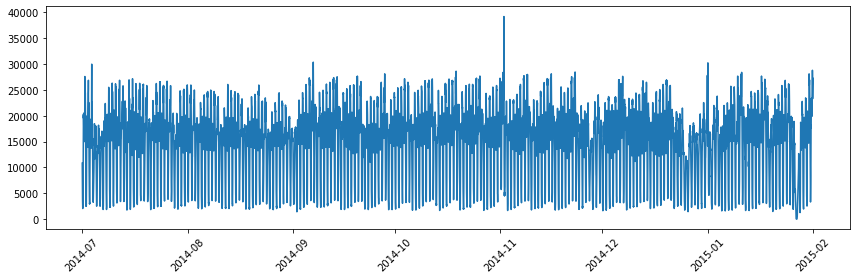

In [7]:
nab.plot_series(data)

## A Look at the Data

**Let's have a look at all the data we loaded**

We can now move to other data structures

In [5]:
labels.head()

0   2014-11-01 19:00:00
1   2014-11-27 15:30:00
2   2014-12-25 15:00:00
3   2015-01-01 01:00:00
4   2015-01-27 00:00:00
dtype: datetime64[ns]

`labels` is a pandas `Series` object

* Similar to a 1D array
* ...But with a well defined row _index_

This series contains the _timestamp of all anomalies_

* They are all hand-labeled

## A Look at the Data

**Let's have a look at all the data we loaded**

Let's plot both the series and the labels:

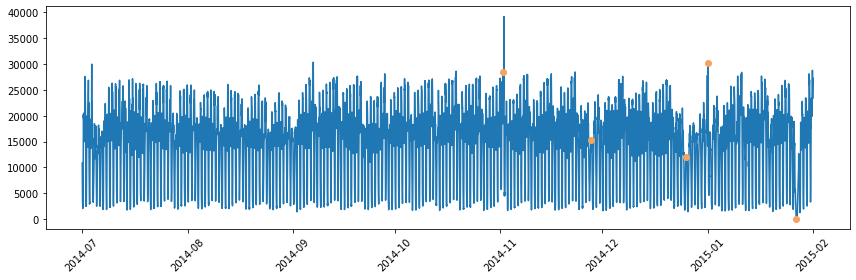

In [6]:
nab.plot_series(data, labels)

* Anomalies occur rarely (typical situation for this kind of problem)

## A Look at the Data

**Let's have a look at all the data we loaded**

Now the "windows" data structure:

In [7]:
windows.head()

,begin,end
0,2014-10-30 15:30:00,2014-11-03 22:30:00
1,2014-11-25 12:00:00,2014-11-29 19:00:00
2,2014-12-23 11:30:00,2014-12-27 18:30:00
3,2014-12-29 21:30:00,2015-01-03 04:30:00
4,2015-01-24 20:30:00,2015-01-29 03:30:00


`windows` is a pandas `DataFrame` object

* Contains the start/end of windows containing anomalies
* They represent a suitable "resolution" for detecting anomalies
* Reporting the presence of anomalies at any point of the window...
* ...Has some value for the company

## A Look at the Data

**Let's have a look at all the data we loaded**

Let's plot the series, the labels, and the windows all together:

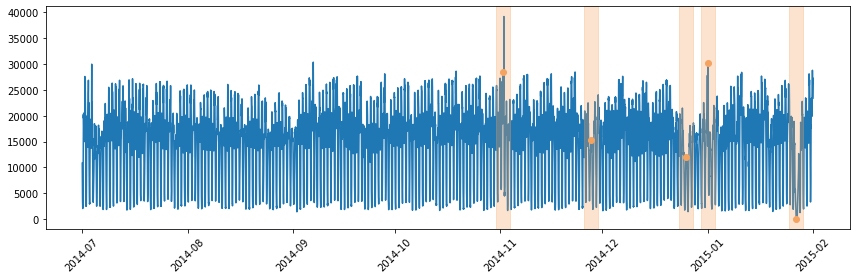

In [8]:
nab.plot_series(data, labels, windows)

* Detections that occur too early/late count as misses 